# Libraries

In [1]:
import nest
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Useful functions

In [2]:
def run_brunel_network(N_total=10000, epsilon=0.1, J_ex=0.1, g=5.0, eta=2.0, sim_time=1100.0):
    '''
    Simulates a Brunel network of spiking neurons using NEST.
    Parameters:
    - N_total: Total number of neurons in the network.
    - epsilon: Connection probability.
    - J_ex: Excitatory synaptic weight amplitude (mV).
    - g: Relative inhibitory strength (J_in = -g * J_ex).
    - eta: External rate relative to threshold.
    - sim_time: Duration of the simulation in milliseconds.
    '''
    # NEST Initialization
    # -------------------
    nest.ResetKernel()
    nest.total_num_virtual_procs = 5
    nest.set_verbosity("M_WARNING")
    nest.rng_seed = 67

    # Parameter Definition
    # -----------------------
    # Network parameters
    NE = int(0.8 * N_total)    # Number of Excitatory neurons
    NI = int(0.2 * N_total)    # Number of Inhibitory neurons
    
    # Connection parameters
    CE = int(epsilon * NE)     # Indegree from Excitatory
    CI = int(epsilon * NI)     # Indegree from Inhibitory

    # Neuron parameters (from Gewaltig et al. 2015)
    tauMem = 20.0  # time constant of membrane potential in ms
    CMem = 1.0  # capacitance of membrane in in pF
    theta = 20.0  # membrane threshold potential in mV
    neuron_params = {
        "C_m": CMem,
        "tau_m": tauMem,
        "t_ref": 2.0,
        "E_L": 0.0,
        "V_reset": 10.0,
        "V_th": theta,
    }
        
    # Synaptic weights
    J_in = -g * J_ex           # Inhibitory weight amplitude
    delay = 1.5                # Synaptic delay (ms)

    # External drive parameters
    nu_th = (theta / (J_ex * CE * tauMem)) * 1000.0   # Threshold rate (Hz) - approximated for parameters
    nu_ext = eta * nu_th       # External Poisson rate (Hz)
    p_rate = nu_ext * CE # Poisson generator rate (spikes/s)

    # Simulation parameters
    dt = 0.1                   # Simulation resolution (ms)

    nest.resolution = dt
    nest.print_time = True
    nest.overwrite_files = True

    print(f"Building network with {N_total} neurons...")

    # Create Nodes
    # ---------------
    # Create neurons (iaf_psc_delta is standard for Brunel 2000)
    nodes_ex = nest.Create("iaf_psc_delta", NE, params=neuron_params)
    nodes_in = nest.Create("iaf_psc_delta", NI, params=neuron_params)
    
    # Create external noise (Poisson generator)
    noise = nest.Create("poisson_generator", params={"rate": p_rate})

    # Create spike recorder for excitatory and inhibitory neurons
    espikes = nest.Create("spike_recorder")
    espikes.set(label="brunel-py-ex")
    ispikes = nest.Create("spike_recorder")
    ispikes.set(label="brunel-py-in")

    # Connect Network
    # ------------------
    # Configure synapse specifications
    syn_ex = {"weight": J_ex, "delay": delay}
    syn_in = {"weight": J_in, "delay": delay}
    
    # Configure connection rule (Fixed Indegree)
    conn_params_ex = {"rule": "fixed_indegree", "indegree": CE}
    conn_params_in = {"rule": "fixed_indegree", "indegree": CI}

    print("Connecting devices...")

    nest.CopyModel("static_synapse", "excitatory", syn_ex)
    nest.CopyModel("static_synapse", "inhibitory", syn_in)
    
    # Connect External Noise -> All Neurons
    nest.Connect(noise, nodes_ex + nodes_in, "all_to_all", syn_spec="excitatory")
    # Connect Excitatory Population -> All Neurons
    nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, syn_ex)
    # Connect Inhibitory Population -> All Neurons
    nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, syn_in)

    # Connect Neurons -> Spike Recorder
    nest.Connect(nodes_ex, espikes, syn_spec="static_synapse")
    nest.Connect(nodes_in, ispikes, syn_spec="static_synapse")

    # Run Simulation
    # -----------------
    print(f"Simulating for {sim_time} ms...")
    nest.Simulate(sim_time)


    return espikes, ispikes

In [3]:
def get_population_rate(spike_times, N_neurons, sim_time, dt_bin=2.0):
    '''
    Calculates the instantaneous population rate A(t) and its distribution.
    
    Parameters:
    - spike_times: List or array of spike timestamps (ms)
    - N_neurons: Number of neurons in the population being analyzed
    - sim_time: Total simulation duration (ms)
    - dt_bin: Width of the time bin for calculation (ms). 
              2.0 ms is usually good for capturing fast oscillations.
    '''
    
    # Define time bins
    bins = np.arange(0, sim_time + dt_bin, dt_bin)
    
    # Bin the spikes (Count spikes per bin)
    spike_counts, _ = np.histogram(spike_times, bins=bins)
    
    # Convert Count -> Rate (Hz)
    # Rate = Count / (Number_of_Neurons * Bin_Width_in_Seconds)
    bin_width_sec = dt_bin / 1000.0
    A_t = spike_counts / (N_neurons * bin_width_sec)
    
    # Remove transient
    # The first ~100ms often contains startup artifacts.
    warmup_bins = int(100 / dt_bin) 
    A_t_steady = A_t[warmup_bins:] 
    
    return bins[:-1], A_t, A_t_steady

In [13]:
import matplotlib.pyplot as plt

def plot_brunel_raster(espikes, ispikes, N_ex, sim_time, max_neurons=500):

    ev_ex = nest.GetStatus(espikes)[0]['events']
    ev_in = nest.GetStatus(ispikes)[0]['events']

    plt.figure(figsize=(10, 6))

    # ---- Excitatory ----
    ex_min = ev_ex['senders'].min()
    mask_ex = ev_ex['senders'] < ex_min + max_neurons

    y_ex = ev_ex['senders'][mask_ex] - ex_min
    plt.plot(ev_ex['times'][mask_ex], y_ex,
            '.', markersize=2, color='navy', label='Excitatory')

    # Number of excitatory neurons actually shown
    n_ex_shown = y_ex.max() + 1

    # ---- Inhibitory ----
    in_min = ev_in['senders'].min()
    max_in = max_neurons // 4
    mask_in = ev_in['senders'] < in_min + max_in

    # ✅ Correct offset
    y_in = n_ex_shown + (ev_in['senders'][mask_in] - in_min)

    plt.plot(ev_in['times'][mask_in], y_in,
            '.', markersize=3, color='crimson', label='Inhibitory')

    # ---- Formatting ----
    plt.title("Brunel Network Raster Plot")
    plt.xlabel("Time (ms)")
    plt.ylabel("Neuron index")
    plt.xlim(0, sim_time)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Network analysis

## Mean firing rate of each population

Building network with 10000 neurons...
Connecting devices...
Simulating for 1000.0 ms...


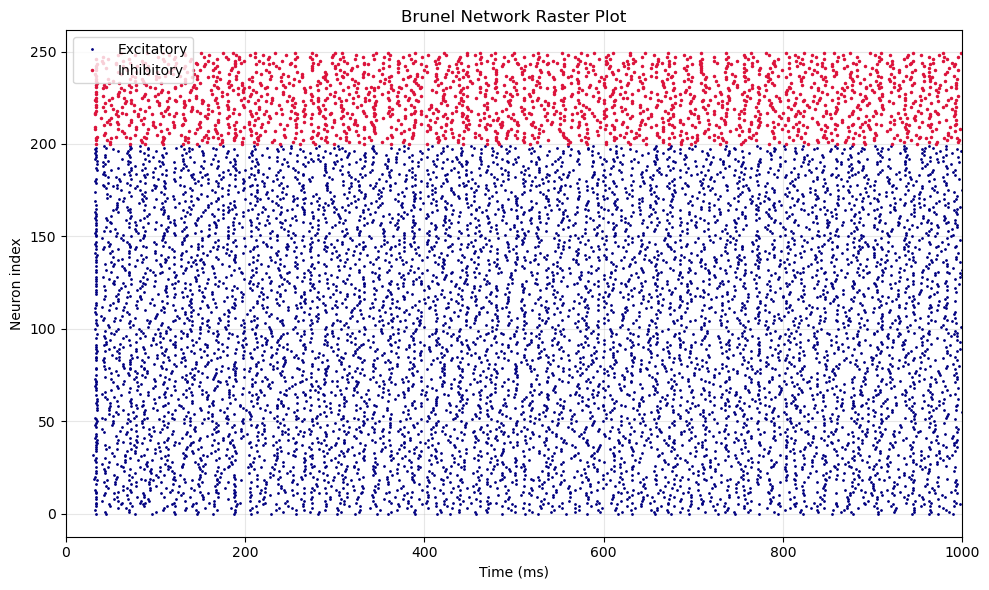

In [14]:
# g=5.0, eta=2.0 usually results in the "Synchronous Irregular" (SI) state
# g=4.5, eta=0.9 usually results in "Asynchronous Irregular" (AI) state
espikes, ispikes = run_brunel_network(
    N_total=10000, 
    g=5.0, 
    eta=2.0, 
    sim_time=1000.0
)

NE = int(0.8 * 10000)
# Plot the results
plot_brunel_raster(espikes, ispikes, NE, sim_time=1000.0, max_neurons=200)

Building network with 10000 neurons...
Connecting devices...
Simulating for 600.0 ms...
Mean Population Rate: 39.48 Hz
Std Dev of Rate: 30.04 Hz
Mean Excitatory Rate: 39.32 Hz
Std Dev of Excitatory Rate: 29.92 Hz
Mean Inhibitory Rate: 40.16 Hz
Std Dev of Inhibitory Rate: 30.70 Hz


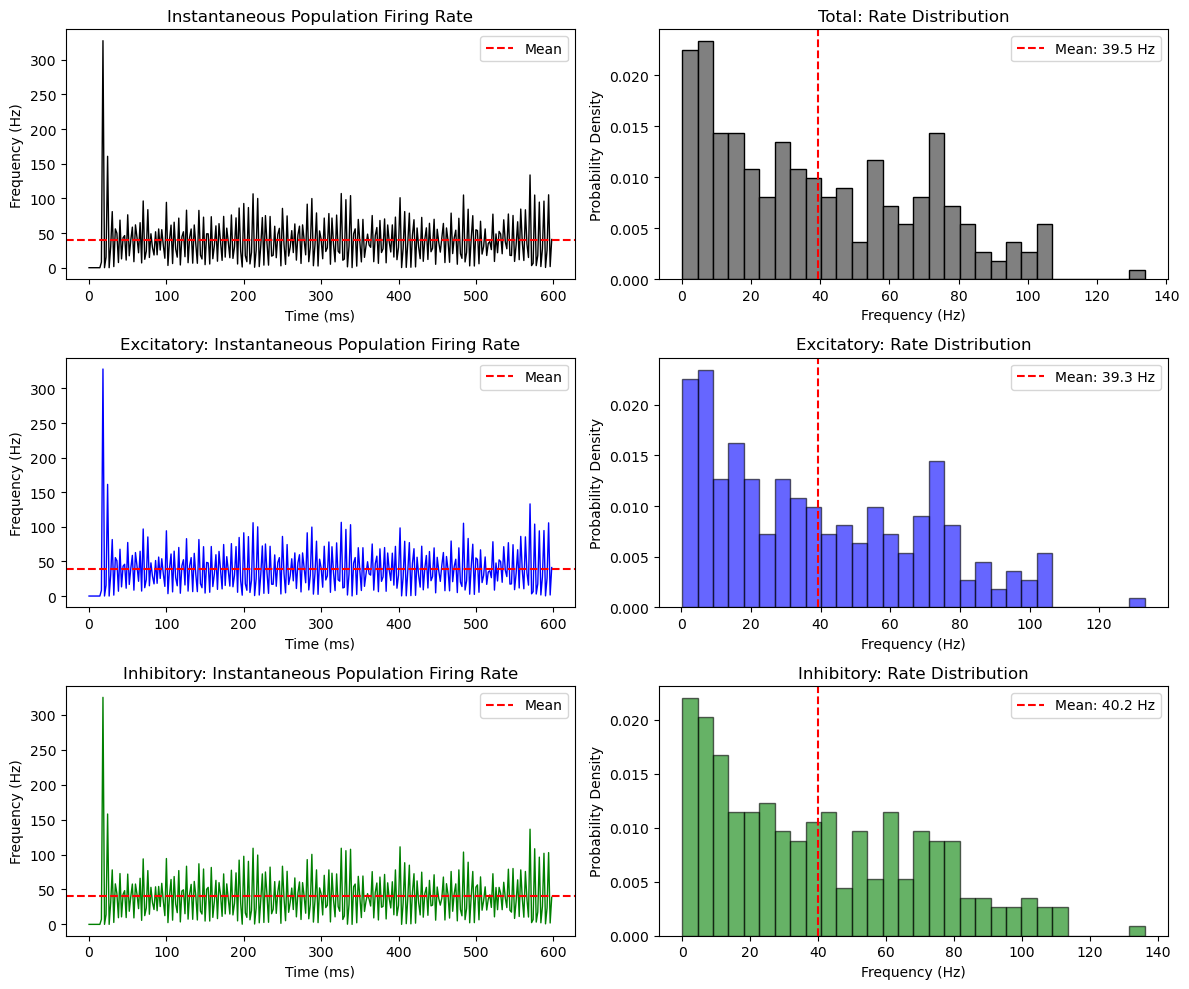

In [22]:
import scipy.stats as stats

sim_time = 600.0
N_total = 10000
NE = int(0.8 * N_total)
NI = int(0.2 * N_total)

espikes, ispikes = run_brunel_network(g=8.0, eta=4.0, sim_time=sim_time)

spikes_ex = nest.GetStatus(espikes, "events")[0]["times"]
spikes_in = nest.GetStatus(ispikes, "events")[0]["times"]
spikes_all = np.concatenate([spikes_ex, spikes_in])

# Calculate Dynamics
time_axis_e, A_t_e, A_t_steady_e = get_population_rate(spikes_ex, NE, sim_time, dt_bin=2.0)
time_axis_i, A_t_i, A_t_steady_i = get_population_rate(spikes_in, NI, sim_time, dt_bin=2.0)
time_axis, A_t, A_t_steady = get_population_rate(spikes_all, N_total, sim_time, dt_bin=2.0)

# Calculate Statistics
mean_rate = np.mean(A_t_steady)
std_rate = np.std(A_t_steady)
mean_rate_e = np.mean(A_t_steady_e)
std_rate_e = np.std(A_t_steady_e)
mean_rate_i = np.mean(A_t_steady_i)
std_rate_i = np.std(A_t_steady_i)

print(f"Mean Population Rate: {mean_rate:.2f} Hz")
print(f"Std Dev of Rate: {std_rate:.2f} Hz")
print(f"Mean Excitatory Rate: {mean_rate_e:.2f} Hz")
print(f"Std Dev of Excitatory Rate: {std_rate_e:.2f} Hz")
print(f"Mean Inhibitory Rate: {mean_rate_i:.2f} Hz")
print(f"Std Dev of Inhibitory Rate: {std_rate_i:.2f} Hz")

# Create the grid
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the 2D array (3x2) into a 1D array of 6 axes
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# --- TOTAL POPULATION (Black) ---
# Plot A(t) - The Time Series
ax1.plot(time_axis, A_t, color='k', lw=1)
ax1.set_title("Instantaneous Population Firing Rate")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Frequency (Hz)")
ax1.axhline(mean_rate, color='red', linestyle='--', label='Mean')
ax1.legend(loc="upper right")

# Plot P(A) - The Distribution
ax2.hist(A_t_steady, bins=30, color='gray', edgecolor='black', density=True)
ax2.set_title("Total: Rate Distribution")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Probability Density")
ax2.axvline(mean_rate, color='red', linestyle='--', label=f'Mean: {mean_rate:.1f} Hz')
ax2.legend(loc="upper right")

# --- EXCITATORY (Blue) ---
ax3.plot(time_axis_e, A_t_e, color='b', lw=1)
ax3.set_title("Excitatory: Instantaneous Population Firing Rate")
ax3.set_xlabel("Time (ms)")
ax3.set_ylabel("Frequency (Hz)")
ax3.axhline(mean_rate_e, color='red', linestyle='--', label='Mean')
ax3.legend(loc="upper right")

ax4.hist(A_t_steady_e, bins=30, color='blue', alpha=0.6, edgecolor='black', density=True)
ax4.set_title("Excitatory: Rate Distribution")
ax4.set_xlabel("Frequency (Hz)")
ax4.set_ylabel("Probability Density")
ax4.axvline(mean_rate_e, color='red', linestyle='--', label=f'Mean: {mean_rate_e:.1f} Hz')
ax4.legend(loc="upper right")

# --- INHIBITORY (Green) ---
ax5.plot(time_axis_i, A_t_i, color='g', lw=1)
ax5.set_title("Inhibitory: Instantaneous Population Firing Rate")
ax5.set_xlabel("Time (ms)")
ax5.set_ylabel("Frequency (Hz)")
ax5.axhline(mean_rate_i, color='red', linestyle='--', label='Mean')
ax5.legend(loc="upper right")

ax6.hist(A_t_steady_i, bins=30, color='green', alpha=0.6, edgecolor='black', density=True)
ax6.set_title("Inhibitory: Rate Distribution")
ax6.set_xlabel("Frequency (Hz)")
ax6.set_ylabel("Probability Density")
ax6.axvline(mean_rate_i, color='red', linestyle='--', label=f'Mean: {mean_rate_i:.1f} Hz')
ax6.legend(loc="upper right")

plt.tight_layout()
plt.show()

We apply a statical comparison test to verify if these distributions are equivalent:

Comparison                     | KS Statistic | P-Value      | Result
---------------------------------------------------------------------------
Excitatory vs Inhibitory       | 0.0400       | 9.89e-01   | Equivalent
Excitatory vs Combined         | 0.0200       | 1.00e+00   | Equivalent
Inhibitory vs Combined         | 0.0320       | 1.00e+00   | Equivalent


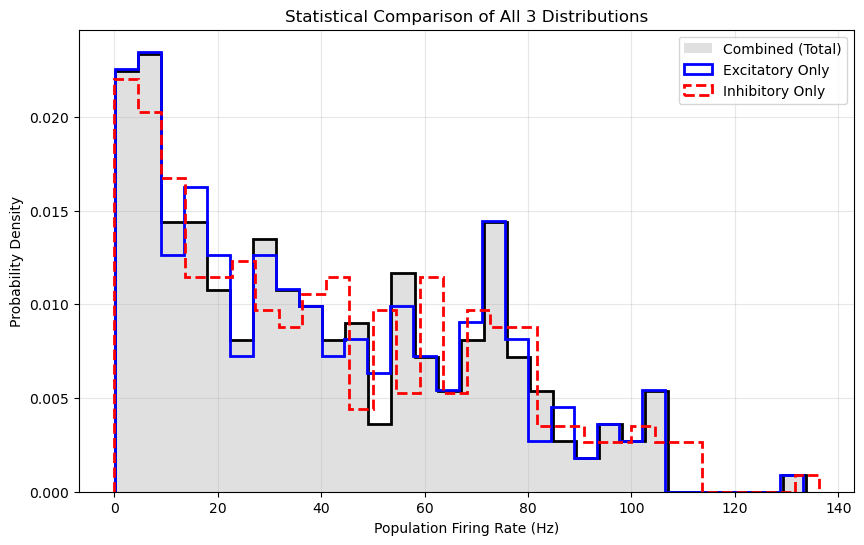

In [21]:
comparisons = [
    ("Excitatory vs Inhibitory", A_t_steady_e, A_t_steady_i),
    ("Excitatory vs Combined",   A_t_steady_e, A_t_steady),
    ("Inhibitory vs Combined",   A_t_steady_i, A_t_steady)
]

print(f"{'Comparison':<30} | {'KS Statistic':<12} | {'P-Value':<12} | {'Result'}")
print("-" * 75)

for label, data1, data2 in comparisons:
    stat, p_val = stats.ks_2samp(data1, data2)
    # If p < 0.05, we reject the null hypothesis (they are different)
    result = "DIFFERENT" if p_val < 0.05 else "Equivalent"
    print(f"{label:<30} | {stat:.4f}       | {p_val:.2e}   | {result}")

# Superimposed Plotting
# ------------------------
plt.figure(figsize=(10, 6))

# We use 'step' histograms to see the lines clearly without blocking each other
# Plot Combined (Black filled) - as the "background" reference
plt.hist(A_t_steady, bins=30, density=True, color='lightgray', alpha=0.7, label='Combined (Total)')
plt.hist(A_t_steady, bins=30, density=True, histtype='step', color='black', lw=2)

# Plot Excitatory (Blue line)
plt.hist(A_t_steady_e, bins=30, density=True, histtype='step', color='blue', lw=2, label='Excitatory Only')

# Plot Inhibitory (Red line)
plt.hist(A_t_steady_i, bins=30, density=True, histtype='step', color='red', lw=2, linestyle='--', label='Inhibitory Only')

plt.title("Statistical Comparison of All 3 Distributions")
plt.xlabel("Population Firing Rate (Hz)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Measurements

In [8]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert, butter, filtfilt

def compute_cv_isi(spike_data_dict):
    """
    Calculates the mean Coefficient of Variation (CV) of ISIs.
    CV = std(ISI) / mean(ISI)
    """
    cv_list = []
    for neuron_id, times in spike_data_dict.items():
        if len(times) > 2:  # Need at least 2 spikes to have an interval
            isi = np.diff(times)
            mean_isi = np.mean(isi)
            if mean_isi > 0:
                cv = np.std(isi) / mean_isi
                cv_list.append(cv)
    
    if len(cv_list) == 0:
        return -1.0
        
    return np.mean(cv_list)

def get_binned_signal(spike_times, t_start, t_stop, dt=2.0):
    """Bins spikes to create a continuous rate signal."""
    bins = np.arange(t_start, t_stop + dt, dt)
    counts, _ = np.histogram(spike_times, bins=bins)
    return counts

def compute_plv(spike_data_dict, t_start, t_stop, n_pairs=100, bin_dt=0.5, freq_band=(10, 100)):
    """
    Calculates Phase Locking Value (PLV) using binned spike trains.
    """
    ids = list(spike_data_dict.keys())
    if len(ids) < 2:
        return 1.0

    # Pre-calculate filter coefficients (Gamma band: 20-80Hz)
    fs = 1000.0 / bin_dt
    nyq = 0.5 * fs
    b, a = butter(4, [freq_band[0]/nyq, freq_band[1]/nyq], btype='band')

    plv_sum = 0.0
    valid_pairs = 0

    # Limit the pool to specific subset to speed up grid search
    # If network is huge, picking 200 neurons at random is statistically sufficient
    subset_size = min(len(ids), 200) 
    subset_ids = np.random.choice(ids, subset_size, replace=False)

    # Convert all subset neurons to analytic signals first (Vectorization opportunity)
    # This prevents re-calculating the Hilbert transform inside the loop
    analytic_signals = {}
    for nid in subset_ids:
        raw_sig = get_binned_signal(spike_data_dict[nid], t_start, t_stop, bin_dt)
        # Handle empty signals
        if np.sum(raw_sig) == 0:
            continue
        filt_sig = filtfilt(b, a, raw_sig)
        analytic_signals[nid] = hilbert(filt_sig)

    available_ids = list(analytic_signals.keys())
    if len(available_ids) < 2:
        return 1.0

    # Average over random pairs
    for _ in range(n_pairs):
        id1, id2 = np.random.choice(available_ids, 2, replace=False)
        
        phase1 = np.angle(analytic_signals[id1])
        phase2 = np.angle(analytic_signals[id2])
        
        # PLV for this pair
        delta_phi = phase1 - phase2
        plv_pair = np.abs(np.mean(np.exp(1j * delta_phi)))
        
        plv_sum += plv_pair
        valid_pairs += 1

    return plv_sum / valid_pairs if valid_pairs > 2 else 1.0

def classify_state(mean_rate, cv_isi, plv):
    """
    Classifies the network state based on mean rate, CV of ISI, and PLV.
    """
    if mean_rate < 1.0 or cv_isi == -1.0:
            return "Q" 

    if plv > 0.3:
        state1 = 'S' # Synchronous
    else:
        state1 = 'A' # Asynchronous

    if cv_isi > 0.7:  # Threshold for Irregularity
        state2 = 'I' # Irregular
    else:
        state2 = 'R' # Regular

    return state1 + state2

In [18]:
import os

g_values = np.linspace(0.0, 8.0, 20)     # Reduced for testing
eta_values = np.linspace(0.0, 4.0, 20)
sim_time = 1100.0                       # Needs to be long enough for PLV
transient = 100.0                       # Ignore first 100ms
N_ex = int(0.8 * 10000)              # Number of excitatory neurons
output_file = "brunel_grid_summary.csv"

data_folder = "spike_data"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Initialize CSV
results_header = ["g", "eta", "mean_rate_ex", "cv_ex", "plv_ex", "classification"]
pd.DataFrame(columns=results_header).to_csv(output_file, index=False)

print(f"Starting Grid Search: {len(g_values)} x {len(eta_values)} runs.")

for g in g_values:
    for eta in eta_values:
        print(f"Running g={g:.1f}, eta={eta:.1f}...", end="\r")
        
        # 1. Run Simulation (Ensure your function returns recorders!)
        espikes, ispikes = run_brunel_network(
            g=g, eta=eta, sim_time=sim_time
        )
        
        # 2. Extract Data (Excitatory Only)
        events = nest.GetStatus(espikes, "events")[0]
        all_times = events['times'] # Raw times for population rate
        
        # --- NEW STEP: Calculate & Save Population Rate ---
        # We calculate the rate for the *Excitatory* population (N_ex)
        time_axis, rate_trace, _ = get_population_rate(all_times, N_ex, sim_time, dt_bin=2.0)
        
        # Save to CSV (Time vs Rate)
        filename = f"rate_g_{g:.1f}_eta_{eta:.1f}.csv"
        filepath = os.path.join(data_folder, filename)
        
        df_rate = pd.DataFrame({
            "time_ms": time_axis,
            "rate_hz": rate_trace
        })
        df_rate.to_csv(filepath, index=False)
        
        mask_clean = all_times > transient
        times_clean = all_times[mask_clean]
        senders_clean = events['senders'][mask_clean]
        
        spikes_by_id = {}
        for nid, t in zip(senders_clean, times_clean):
            spikes_by_id.setdefault(nid, []).append(t)
            
        # 3. Calculate Metrics
        # Rate
        rate_ex = len(times_clean) / (N_ex * (sim_time - transient) / 1000.0)
        
        # CV (Coefficient of Variation)
        cv_ex = compute_cv_isi(spikes_by_id)
        
        # PLV (Phase Locking Value)
        # Only compute if there's reasonable activity (e.g., > 0.1 Hz)
        if rate_ex > 0.1:
            plv_ex = compute_plv(spikes_by_id, transient, sim_time)
        else:
            plv_ex = 1.0

        # Classification
        classification = classify_state(rate_ex, cv_ex, plv_ex)

        # 4. Save Results
        df_res = pd.DataFrame({
            "g": [g],
            "eta": [eta],
            "mean_rate_ex": [rate_ex],
            "cv_ex": [cv_ex],
            "plv_ex": [plv_ex],
            "classification": [classification]
        })
        df_res.to_csv(output_file, mode='a', header=False, index=False)

print("\nGrid search complete. Results saved.")

Starting Grid Search: 20 x 20 runs.
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating for 1100.0 ms...
Building network with 10000 neurons...
Connecting devices...
Simulating fo

<>:33: SyntaxWarning:invalid escape sequence '\e'
<>:33: SyntaxWarning:invalid escape sequence '\e'
/tmp/ipykernel_13763/2485900017.py:33: SyntaxWarning:invalid escape sequence '\e'


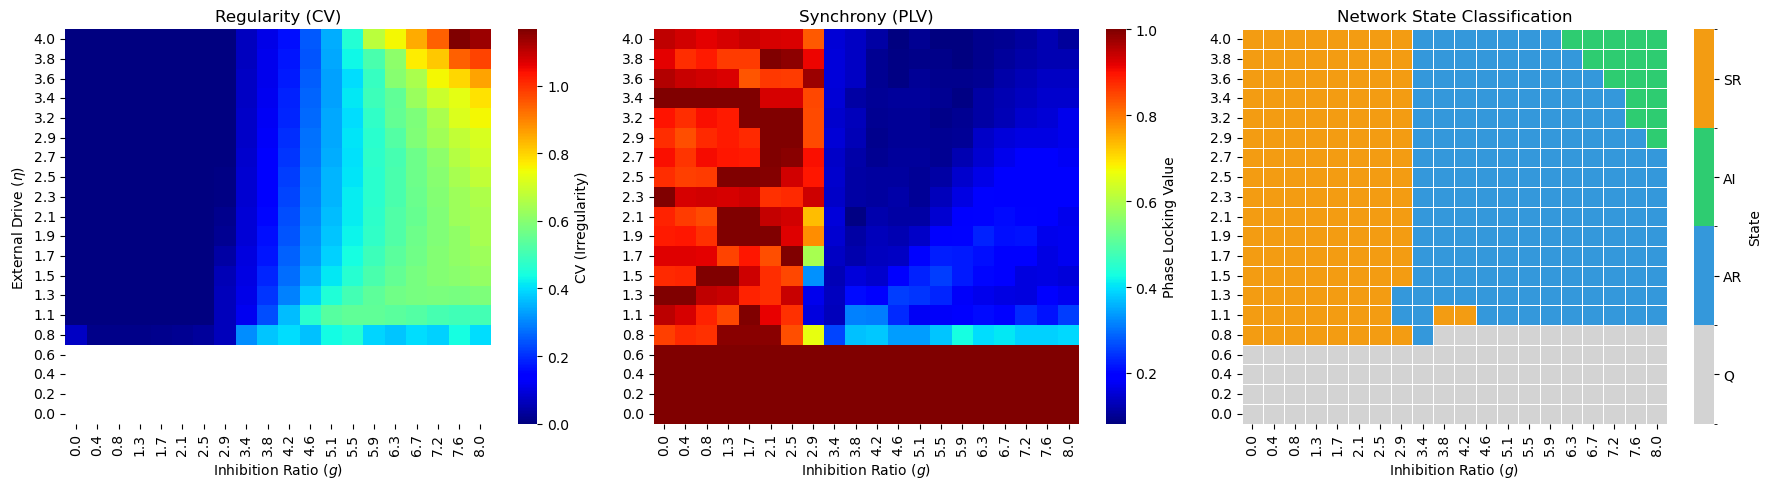

In [19]:
import matplotlib.colors as colors
import seaborn as sns

df = pd.read_csv("brunel_grid_summary.csv")

df['g'] = df['g'].round(1)
df['eta'] = df['eta'].round(1)
df['cv_ex'] = df['cv_ex'].replace(-1.0, np.nan)

# 2. Map Categorical Labels to Integers for Plotting
# --------------------------------------------------
# Define your states. We assign an integer to each state so the heatmap knows which color to use.
# Added 'SI' just in case, though your snippet only shows Q, SR, AR, AI
state_map = {'Q': 0, 'AR': 1, 'AI': 2, 'SR': 3, 'SI': 4}
df['state_code'] = df['classification'].map(state_map)

# 3. Pivot Data for Heatmaps
# --------------------------
# Pivot creates the matrix grid (Y=eta, X=g)
cv_matrix = df.pivot(index="eta", columns="g", values="cv_ex").sort_index(ascending=False)
plv_matrix = df.pivot(index="eta", columns="g", values="plv_ex").sort_index(ascending=False)
state_matrix = df.pivot(index="eta", columns="g", values="state_code").sort_index(ascending=False)

# 4. Create the Plots
# -------------------
fig = plt.figure(figsize=(18, 5))
gs = fig.add_gridspec(1, 3) # 1 row, 3 columns

# --- Plot 1: CV Heatmap ---
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cv_matrix, ax=ax1, cmap="jet", annot=False, fmt=".2f", cbar_kws={'label': 'CV (Irregularity)'})
ax1.set_title("Regularity (CV)")
ax1.set_ylabel("External Drive ($\eta$)")
ax1.set_xlabel("Inhibition Ratio ($g$)")

# --- Plot 2: PLV Heatmap ---
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(plv_matrix, ax=ax2, cmap="jet", annot=False, fmt=".2f", cbar_kws={'label': 'Phase Locking Value'})
ax2.set_title("Synchrony (PLV)")
ax2.set_ylabel("")
ax2.set_xlabel("Inhibition Ratio ($g$)")

# --- Plot 3: Classification Phase Diagram ---
ax3 = fig.add_subplot(gs[0, 2])

# Define exact colors for your labels
# Q=Gray, AR=Blue, AI=Green, SR=Orange, SI=Red
cmap_colors = ['#d3d3d3', '#3498db', '#2ecc71', '#f39c12', '#e74c3c']
labels = ['Q', 'AR', 'AI', 'SR', 'SI']

# We must ensure the colors match the exact integers present in the data
# Filter labels/colors to only those that actually appear in your dataset
present_codes = sorted(df['state_code'].unique())
present_labels = [list(state_map.keys())[list(state_map.values()).index(c)] for c in present_codes]
present_colors = [cmap_colors[c] for c in present_codes]

# Create a custom colormap for the discrete states
cmap = colors.ListedColormap(present_colors)
bounds = np.array(present_codes + [present_codes[-1] + 1]) - 0.5
norm = colors.BoundaryNorm(bounds, cmap.N)

sns.heatmap(
    state_matrix, 
    ax=ax3, 
    cmap=cmap, 
    norm=norm,
    annot=False,     # Display the numeric code (optional, or turn off)
    fmt=".2f",
    cbar_kws={"ticks": present_codes, "label": "State"},
    linewidths=0.5, 
    linecolor='white'
)

# Fix the colorbar text to show state names (Q, SR, etc) instead of numbers
cbar = ax3.collections[0].colorbar
cbar.set_ticklabels(present_labels)

ax3.set_title("Network State Classification")
ax3.set_ylabel("")
ax3.set_xlabel("Inhibition Ratio ($g$)")

plt.tight_layout()
plt.show()

## Evaluating the Tsalis Entropy

<>:144: SyntaxWarning: invalid escape sequence '\e'
<>:144: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_67780/1256120315.py:144: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel("Drive ($\eta$)")


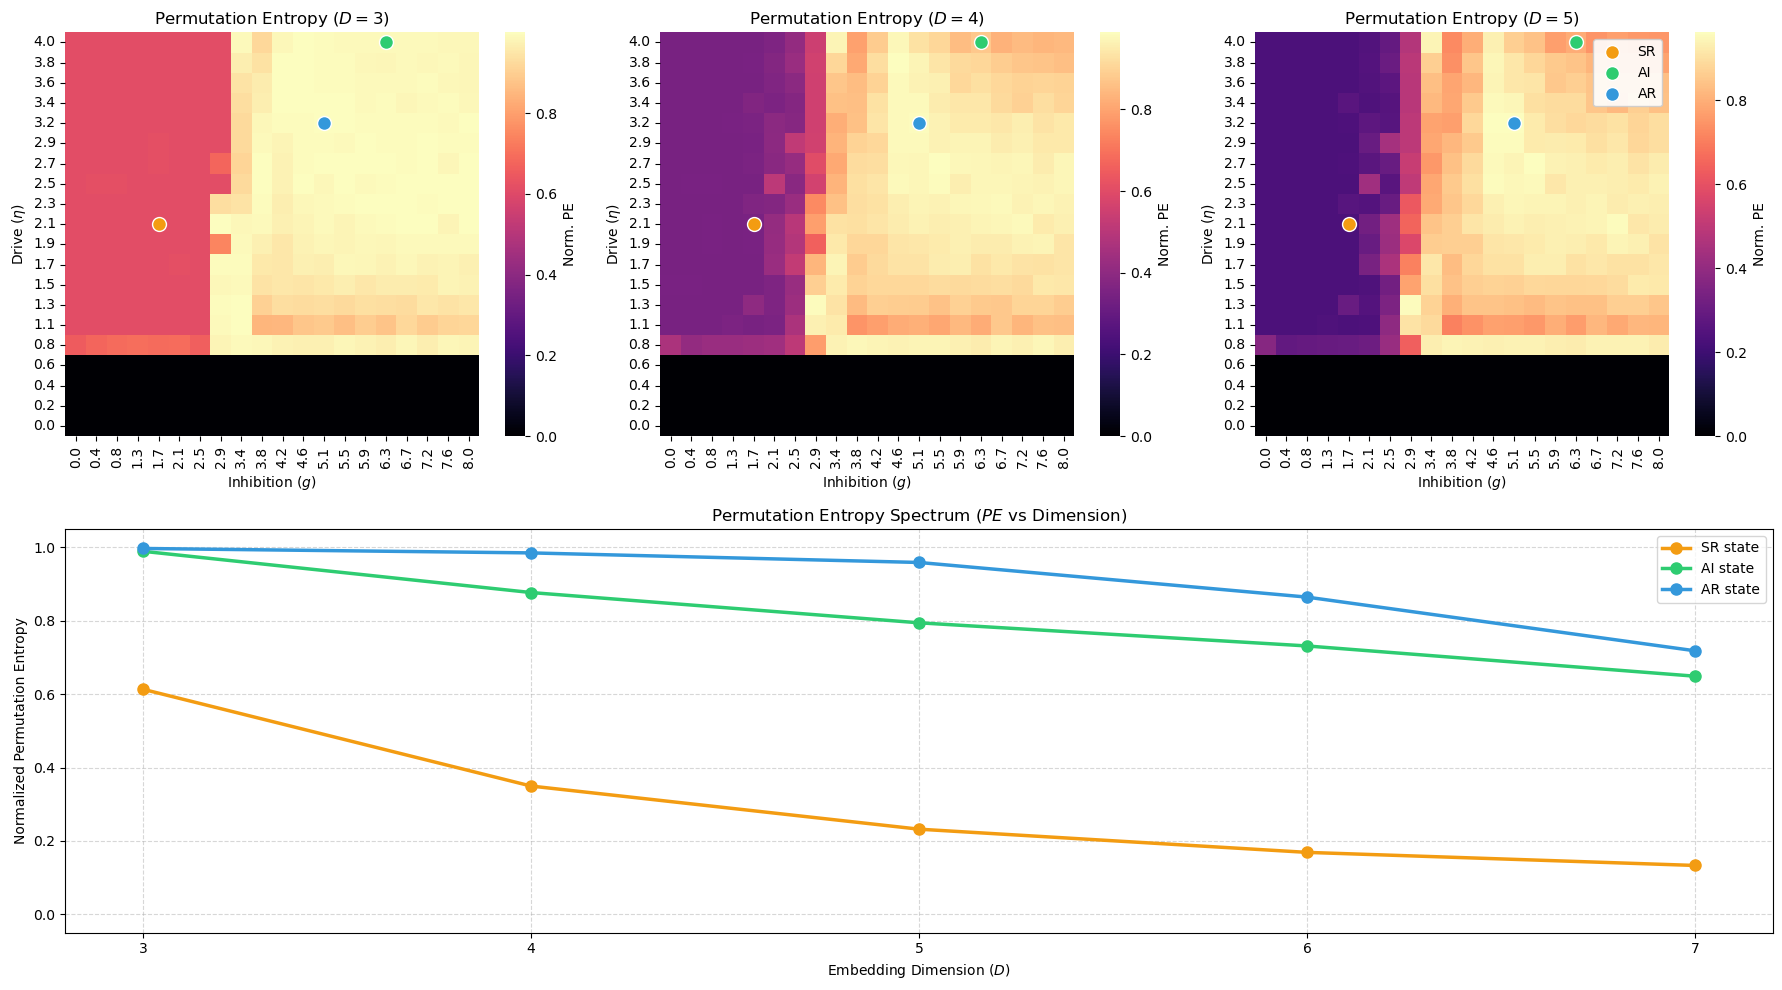

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

def calculate_permutation_entropy(time_series, D, delay=1, normalize=True):
    """
    Calculates Permutation Entropy (PE).
    Args:
        time_series: The signal array.
        D (int): Embedding dimension (order of permutation).
        delay (int): Time delay (tau).
        normalize (bool): If True, divides by log2(D!) to normalize between 0 and 1.
    """
    n = len(time_series)
    
    # Validation: time series must be longer than the embedding vector
    if n < D + (D - 1) * (delay - 1):
        return 0.0

    # 1. Create Embedding Matrix
    # We slice the array to get D-dimensional vectors
    # E.g. for D=3: [x(t), x(t+1), x(t+2)]
    embeddings = np.array([time_series[i : i + D * delay : delay] 
                           for i in range(n - (D - 1) * delay)])
    
    # 2. Get Ordinal Patterns (Permutations)
    # argsort gives us the indices that would sort the vector
    # e.g., [10, 5, 12] -> [1, 0, 2] (index 1 is smallest, then 0, then 2)
    sorted_idx = np.argsort(embeddings, axis=1)
    
    # 3. Count Unique Patterns
    _, counts = np.unique(sorted_idx, return_counts=True, axis=0)
    
    # 4. Calculate Probabilities
    p = counts / counts.sum()
    p = p[p > 0] # Avoid log(0)
    
    # 5. Shannon Entropy of the patterns
    pe = -np.sum(p * np.log2(p))
    
    # 6. Normalize
    if normalize:
        S_max = np.log2(math.factorial(D))
        return pe / S_max
    else:
        return pe

# --- 2. Setup & Data Loading ---
data_folder = "spike_data"

# CHANGED: Instead of 'q', we vary the Embedding Dimension (D)
# D determines the length of the pattern we look for (e.g., 3 points, 4 points...)
# Note: D values must be integers.
dim_range = np.arange(3, 8) # Spectrum from D=3 to D=7
# Specific dimensions for the heatmaps
heatmap_dims = [3, 4, 5]

# --- 3. Define Representative Points ---
points_of_interest = {
    "SR": (1.7, 2.1),  
    "AI": (6.3, 4.0),  
    "AR": (5.1, 3.2),  
}

state_colors = {
    "SR": "#f39c12", 
    "AI": "#2ecc71", 
    "SI": "#e74c3c", 
    "AR": "#3498db", 
    "Q":  "#7f8c8d"  
}

# --- 4. Calculate Entropy Grids (for Heatmaps) ---
g_values = np.linspace(0.0, 8.0, 20)
eta_values = np.linspace(0.0, 4.0, 20)
heatmap_results = []

for g in g_values:
    for eta in eta_values:
        filepath = os.path.join(data_folder, f"rate_g_{g:.1f}_eta_{eta:.1f}.csv")
        row = {'g': round(g, 1), 'eta': round(eta, 1)}
        try:
            df = pd.read_csv(filepath)
            # Use same mask as before
            mask = df['time_ms'] > 100
            rate = df.loc[mask, 'rate_hz'].values # Convert to numpy array for speed
            
            if len(rate) > 0:
                for D in heatmap_dims:
                    # CHANGED: Calling permutation entropy
                    row[f'PE_{D}'] = calculate_permutation_entropy(rate, D=D)
            else:
                for D in heatmap_dims:
                    row[f'PE_{D}'] = 0.0
        except FileNotFoundError:
            continue
        heatmap_results.append(row)

df_heat = pd.DataFrame(heatmap_results)

# --- 5. Calculate Spectra (for Line Plot) ---
spectrum_data = {} # Stores {State: [PE values...]}

for label, (g_target, eta_target) in points_of_interest.items():
    fname = f"rate_g_{g_target:.1f}_eta_{eta_target:.1f}.csv"
    fpath = os.path.join(data_folder, fname)
    
    entropies = []
    
    if os.path.exists(fpath):
        df = pd.read_csv(fpath)
        rate = df[df['time_ms'] > 100]['rate_hz'].values
        
        if len(rate) == 0 or rate.mean() < 0.1:
            entropies = [0.0] * len(dim_range)
        else:
            for D in dim_range:
                # CHANGED: Loop over dimensions
                entropies.append(calculate_permutation_entropy(rate, D=D))
    else:
        print(f"Warning: File for {label} not found.")
        entropies = [np.nan] * len(dim_range)
        
    spectrum_data[label] = entropies

# --- 6. PLOTTING ---
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3) 

# ROW 1: Heatmaps
for i, D in enumerate(heatmap_dims):
    ax = fig.add_subplot(gs[0, i])
    
    # Pivot using the new column names
    matrix = df_heat.pivot(index="eta", columns="g", values=f'PE_{D}')
    matrix = matrix.sort_index(ascending=False)
    
    sns.heatmap(matrix, ax=ax, cmap="magma", cbar_kws={'label': 'Norm. PE'})
    ax.set_title(f"Permutation Entropy ($D={D}$)")
    ax.set_xlabel("Inhibition ($g$)")
    ax.set_ylabel("Drive ($\eta$)")
    
    # Overlay Points
    for label, (g_pt, eta_pt) in points_of_interest.items():
        g_idx = np.abs(g_values - g_pt).argmin()
        eta_idx = np.abs(eta_values - eta_pt).argmin()
        y_pos = len(eta_values) - 1 - eta_idx
        x_pos = g_idx
        
        ax.scatter(x_pos + 0.5, y_pos + 0.5, 
                   color=state_colors[label], edgecolors='white', 
                   s=100, label=label, zorder=10)

# Legend (same logic as before)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right', framealpha=0.9)

# ROW 2: Spectrum Plot
ax_spec = fig.add_subplot(gs[1, :])

for label, pe_values in spectrum_data.items():
    ax_spec.plot(dim_range, pe_values, 
                 label=f"{label} state",
                 color=state_colors[label], linewidth=2.5, marker='o', markersize=8)

ax_spec.set_title("Permutation Entropy Spectrum ($PE$ vs Dimension)")
ax_spec.set_xlabel("Embedding Dimension ($D$)")
ax_spec.set_ylabel("Normalized Permutation Entropy")
ax_spec.set_ylim(-0.05, 1.05)
ax_spec.set_xticks(dim_range) # Force integer ticks
ax_spec.grid(True, which='both', linestyle='--', alpha=0.5)
ax_spec.legend()

plt.tight_layout()
plt.show()